### Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import os
import pywt

#### Load VAE Model

In [9]:
device = torch.device('cpu')
transform = T.ToPILImage()
model = torch.load('model_autoencoder.ts')
model = model.double()

### Preprocessing, Denoising and Prediction functions

In [10]:


def dwt_threshold(original_signal, wavelet='db1', level=1):
    coeffs = pywt.wavedec(original_signal, wavelet, level=level)
    return coeffs

def apply_threshold(coeffs, threshold_value, mode='hard'):
    thresholded_coeffs = [pywt.threshold(coeff, threshold_value, mode=mode) for coeff in coeffs]
    return thresholded_coeffs

def idwt_reconstruct(coeffs, wavelet='db1'):
    denoised_signal = pywt.waverec(coeffs, wavelet)
    return denoised_signal

def apply_wavelet_denoising(original_signal, wavelet ='db1', level = 1, threshold_value = 0.1, threshold_mode = 'hard') : 
    coeffs = dwt_threshold(original_signal, wavelet, level)
    thresholded_coeffs = apply_threshold(coeffs, threshold_value, mode=threshold_mode)
    denoised_signal = idwt_reconstruct(thresholded_coeffs, wavelet)
    return denoised_signal


def process_image(img,i, wavelet, if_wavelet= False) :
    img_array = np.array(diseased_img[:,:,i])
    print(img_array.shape)
    img_array = (img_array - img_array.min())/(img_array.max() - img_array.min())
    
    if if_wavelet : 
        #img_array = np.ones(img_array.shape) - img_array
        img_array = apply_wavelet_denoising(original_signal = img_array, wavelet =wavelet, level = 1, threshold_value = 0.25, threshold_mode = 'soft')
        #img_array = np.ones(img_array.shape) - img_array
    img_array = np.moveaxis(img_array,2,0)
    img_tensor = torch.from_numpy(img_array)
    img_tensor = torch.unsqueeze(img_tensor,0)
    img_tensor = torch.unsqueeze(img_tensor,0)
    img_tensor=img_tensor.type(torch.double)
    img_tensor=img_tensor.type(torch.double)
    y_pred = model(img_tensor)
    img_arr = y_pred[0].detach().cpu().numpy()
    #img_arr[img_arr < 0.05] = 0
    img_arr = np.squeeze(img_arr)
    img_arr = (img_arr - img_arr.min())/(img_arr.max() - img_arr.min())
    img_arr = np.moveaxis(img_arr,0,2)
    img_array = np.moveaxis(img_array,0,2)
    return img_array, img_arr

def plot_anomaly_map(original_img, new_img) :
    
    anomaly =  -normalize(new_img) +normalize(original_img)
    anomaly[anomaly<0] = 0
    anomaly = (anomaly - anomaly.min())/(anomaly.max() - anomaly.min())
    plt.colorbar(plt.imshow(anomaly, cmap='viridis', vmin=0, vmax=1))
    plt.cm.hot(anomaly)
    #plt.grid(None)
    plt.show()


def get_dice(recons, orig):
    intersect = np.sum(recons==orig)
    #intersect[intersect < 0.05] = 0
    dice = 2*intersect/((orig.shape[0]*orig.shape[1])+(recons.shape[0]*recons.shape[1]))
    return dice

def normalize(x):
    norm = (x - x.min())/(x.max() - x.min())
    return norm


def complete_pipeline(diseased_img, diseased_label, if_wavelet) :

        ### Denosing and Reconstruction
        wavelet = 'bior3.1'
        original_total, recon_total= process_image(diseased_img[:,:,:,:], 81, wavelet, if_wavelet)

        ### Anomaly Map Plot and DICE Score Calculation
        for each in range(0,1) :
            channel = each
            plot_anomaly_map(original_total[:,:,channel],recon_total[:,:,channel])
            
            norm_recon = normalize(recon_total)[:,:,channel]
            original = normalize(original_total)[:,:,channel]
            diseased_label[diseased_label > 0] = 1
            anomaly = -norm_recon + original
            anomaly = normalize(anomaly)
            perc_threshold = np.percentile(anomaly, 30)
            anomaly[anomaly > perc_threshold] = 1
            anomaly[anomaly<= perc_threshold] = 0
            dice = get_dice(anomaly, diseased_label[:,:,81])
            original_images.append(original)
            reconstructed_images.append(norm_recon)
            dice_score.append(dice)
            if if_wavelet : 
                print("Dice Score with Denoising" , ' -> ', str(dice))
            else :
                print("Dice Score without Denoising" , ' -> ', str(dice))
        return dice

### Reconstruction, Anomaly Map and DICE Score

(240, 240, 4)


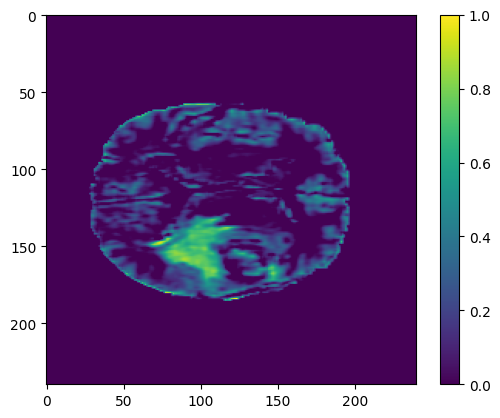

Dice Score without Denoising  ->  0.29864583333333333
(240, 240, 4)


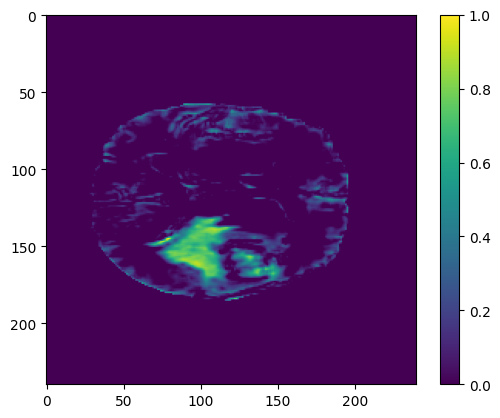

Dice Score with Denoising  ->  0.32232638888888887


In [8]:
original_images = []
reconstructed_images = []
dice_score = []

for i in range(1,2) :
    
    diseased_img = nib.load('/Users/manasamangipudi/Desktop/Semester-1/MLForInverseProblems/Anomaly-MRI/trial-data/Task01_BrainTumour/imagesTr/BRATS_00'+str(i)+'.nii.gz').get_fdata()
    diseased_label = nib.load('/Users/manasamangipudi/Desktop/Semester-1/MLForInverseProblems/Anomaly-MRI/trial-data/Task01_BrainTumour/labelsTr/BRATS_00'+str(i)+'.nii.gz').get_fdata()
    
    #### Noisy Image Reconstruction and Anomaly Map
    complete_pipeline(diseased_img, diseased_label, False)

    #### Denoised Image Reconstruction and Anomaly Map    
    complete_pipeline(diseased_img, diseased_label, True)

### Original Image and Segment of the above Anomaly Maps

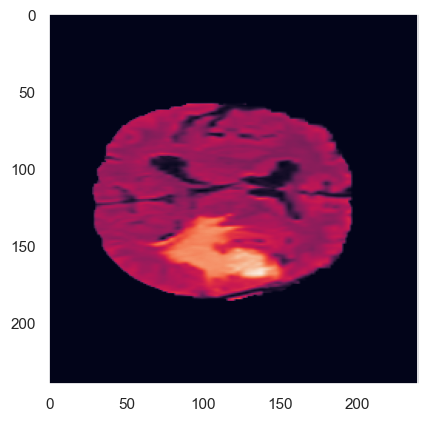

In [122]:
plt.imshow(diseased_img[:,:,81,0])
plt.grid(None)

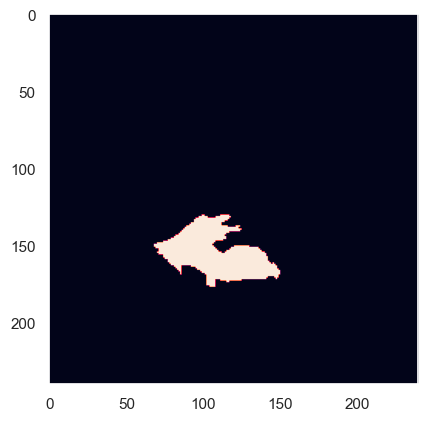

In [123]:
plt.imshow(diseased_label[:, :, 81])
plt.grid(None)

### Test Results and Analysis

In [65]:
test_repo = "/Users/manasamangipudi/Desktop/Semester-1/MLForInverseProblems/Anomaly-MRI/trial-data/Task01_BrainTumour/"
images_folder = "imagesTr"
labels_folder = "labelsTr"
dice_score_without_denoising = []
dice_score_with_denoising = []

for i in range(1,50) :
    
    diseased_img = nib.load(test_repo +images_folder+'/BRATS_' + f'{i:03}' + ".nii.gz").get_fdata()
    diseased_label = nib.load(test_repo +labels_folder+'/BRATS_'+ f'{i:03}' + ".nii.gz").get_fdata()
    dice_score_without_denoising.append(complete_pipeline(diseased_img, diseased_label, False))
    dice_score_with_denoising.append(complete_pipeline(diseased_img, diseased_label, True))

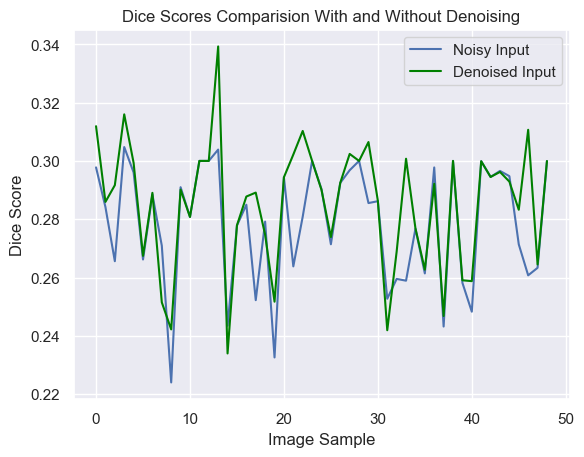

In [63]:
import seaborn as sns
sns.set(style="darkgrid")
sns.lineplot(dice_score_without_denoising,label = 'Noisy Input' )
plt.legend()
sns.lineplot(dice_score_with_denoising,color = 'green', label = 'Denoised Input')
plt.legend()
plt.title("Dice Scores Comparision With and Without Denoising")
plt.xlabel('Image Sample')
plt.ylabel('Dice Score')
plt.savefig('DICEScore-Comparision.png')
plt.show()

In [126]:
print("Mean DICE Score for Autoencoder without Denoising", np.mean(dice_score_without_denoising))
print("Mean DICE Score for Autoencoder with Denoising", np.mean(dice_score_with_denoising))

Mean DICE Score for Autoencoder without Denoising 0.27843501984126984
Mean DICE Score for Autoencoder with Denoising 0.2854793792517007
